Voici un algorithme permettant de faire la reconnaissance de genre de musique, j'ai utilisé une base de données déjà prête sur Kaggle: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

Pour réaliser cet algorithme j'ai calculé pour chaque musique sa MFCC 

In [ ]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
import h5py
import librosa
import itertools
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
!git clone https://github.com/NazarPonochevnyi/Trained-CNN-for-Genre-classification
path = "./Trained-CNN-for-Genre-classification/gtzan/"


Cloning into 'Trained-CNN-for-Genre-classification'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 87 (delta 3), reused 0 (delta 0), pack-reused 78
Unpacking objects: 100% (87/87), 31.26 MiB | 12.34 MiB/s, done.


In [ ]:
def read_data(src_dir, genres, song_samples, spec_format, limit=1000, debug=True):
    # Empty arrays to store the processed features and labels
    arr_specs = []
    arr_genres = []

    # Counter for the number of songs read
    count = 0

    # Read files from the folders
    for x, _ in genres.items():
        folder = src_dir + x

        for root, subdirs, files in os.walk(folder):
            for file in files:
                if count >= limit:
                    break

                # Read the audio file and extract features
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                if len(signal) < song_samples:
                    print('Error in {}\nNum of samples ( >= {}): {}'.format(file_name, song_samples, len(signal)))
                signal = signal[:song_samples]

                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))

                # Convert to dataset of spectrograms
                signals, y = splitsongs(signal, genres[x])

                # Convert to spectrogram representation
                specs = spec_format(signals)

                # Save the features and labels
                arr_genres.extend(y)
                arr_specs.extend(specs)

                # Increment the counter
                count += 1

    return np.array(arr_specs), np.array(arr_genres)


In [ ]:
def to_melspectrogram(songs, n_fft = 1024, hop_length = 512):
    # Empty array to hold the results
    tsongs = []

    # Loop through each song
    for song in songs:
        # Convert the song to a melspectrogram using librosa
        melspec = librosa.feature.melspectrogram(y=song, n_fft=n_fft, hop_length=hop_length)

        # Expand the dimensions of the melspectrogram
        melspec = melspec[..., np.newaxis]
        # Append the melspectrogram to our results array
        tsongs.append(melspec)

    return np.array(tsongs)


In [ ]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.1, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [ ]:
# Parameters
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}
x, y = read_data(path, genres, song_samples, to_melspectrogram, limit=1000, debug=True)

# One hot encoding of the labels


Reading file: ./Trained-CNN-for-Genre-classification/gtzan/metal/metal.00000.au
Reading file: ./Trained-CNN-for-Genre-classification/gtzan/disco/disco.00000.au
Reading file: ./Trained-CNN-for-Genre-classification/gtzan/classical/classical.00000.au
Reading file: ./Trained-CNN-for-Genre-classification/gtzan/hiphop/hiphop.00000.au
Reading file: ./Trained-CNN-for-Genre-classification/gtzan/jazz/jazz.00000.au
Reading file: ./Trained-CNN-for-Genre-classification/gtzan/country/country.00000.au
Reading file: ./Trained-CNN-for-Genre-classification/gtzan/pop/pop.00000.au
Reading file: ./Trained-CNN-for-Genre-classification/gtzan/blues/blues.00000.au
Reading file: ./Trained-CNN-for-Genre-classification/gtzan/reggae/reggae.00000.au
Reading file: ./Trained-CNN-for-Genre-classification/gtzan/rock/rock.00000.au


In [ ]:
y = to_categorical(y)

In [ ]:
X_stack = np.squeeze(np.stack((x,) * 3, -1))
X_stack.shape
X_train, X_test, y_train, y_test = train_test_split(X_stack, y, test_size=0.3, random_state=42, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(133, 128, 129, 3) (57, 128, 129, 3) (133, 10) (57, 10)


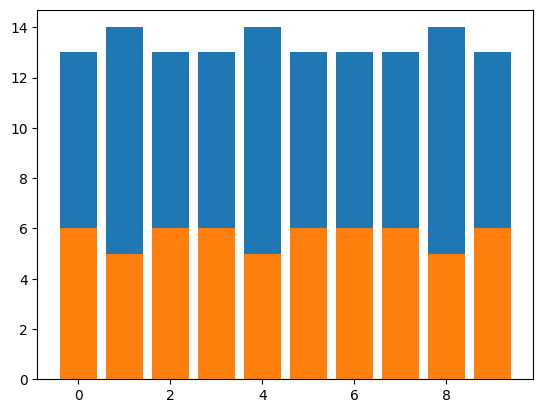

In [ ]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

In [ ]:
# Model Definition
input_shape = X_train[0].shape
num_genres = 10

def cnn_vgg16(input_shape, num_genres, freezed_layers):
    input_tensor = Input(shape=input_shape)
    vgg16 = VGG16(include_top=False, weights='imagenet',
                  input_tensor=input_tensor)

    top = Sequential()
    top.add(Flatten(input_shape=vgg16.output_shape[1:]))
    top.add(Dense(256, activation='relu'))
    top.add(Dropout(0.5))
    top.add(Dense(num_genres, activation='softmax'))

    model = Model(inputs=vgg16.input, outputs=top(vgg16.output))
    for layer in model.layers[:freezed_layers]:
        layer.trainable = False

    return model

model = cnn_vgg16(input_shape, num_genres, 5)
print("Creating EarlyStopping Callback ...")
early_stopping_callback = EarlyStopping(monitor='val_acc', patience=5)
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Creating EarlyStopping Callback ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 129, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 129, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 129, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                          

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

hist = model.fit(X_train, y_train,
          batch_size=5,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test),
          shuffle=True,
          callbacks=[early_stopping_callback])
print("Learning stoped on epoch:", early_stopping_callback.stopped_epoch)

Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 15.1649 - accuracy: 0.0977

27/27 [==============================] - 102s 4s/step - loss: 15.1649 - accuracy: 0.0977 - val_loss: 2.2694 - val_accuracy: 0.2281
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 2.2660 - accuracy: 0.1654

27/27 [==============================] - 90s 3s/step - loss: 2.2660 - accuracy: 0.1654 - val_loss: 2.1894 - val_accuracy: 0.1930
Epoch 3/10
27/27 [==============================] - ETA: 0s - loss: 2.2283 - accuracy: 0.1805

27/27 [==============================] - 99s 4s/step - loss: 2.2283 - accuracy: 0.1805 - val_loss: 2.1550 - val_accuracy: 0.1053
Epoch 4/10
27/27 [==============================] - ETA: 0s - loss: 2.0915 - accuracy: 0.2105

27/27 [==============================] - 99s 4s/step - loss: 2.0915 - accuracy: 0.2105 - val_loss: 1.9843 - val_accuracy: 0.2281
Epoch 5/10
27/27 [==============================] - ETA: 0s - loss: 2.7792 - accuracy: 0.2030

27/27 [==============================] - 99s 4s/step - loss: 2.7792 - accuracy: 0.2030 - val_loss: 2.1114 - val_accuracy: 0.1404
Epoch 6/10
27/27 [==============================] - ETA: 0s - loss: 2.1969 - accuracy: 0.1955

27/27 [==============================] - 89s 3s/step - loss: 2.1969 - accuracy: 0.1955 - val_loss: 1.9157 - val_accuracy: 0.2281
Epoch 7/10
27/27 [==============================] - ETA: 0s - loss: 1.7893 - accuracy: 0.2857

27/27 [==============================] - 99s 4s/step - loss: 1.7893 - accuracy: 0.2857 - val_loss: 1.7879 - val_accuracy: 0.3509
Epoch 8/10
27/27 [==============================] - ETA: 0s - loss: 1.9840 - accuracy: 0.2782

27/27 [==============================] - 101s 4s/step - loss: 1.9840 - accuracy: 0.2782 - val_loss: 1.9067 - val_accuracy: 0.2456
Epoch 9/10
27/27 [==============================] - ETA: 0s - loss: 1.8970 - accuracy: 0.2556

27/27 [==============================] - 89s 3s/step - loss: 1.8970 - accuracy: 0.2556 - val_loss: 1.7040 - val_accuracy: 0.3684
Epoch 10/10
27/27 [==============================] - ETA: 0s - loss: 1.6723 - accuracy: 0.3383

27/27 [==============================] - 94s 3s/step - loss: 1.6723 - accuracy: 0.3383 - val_loss: 1.4620 - val_accuracy: 0.4211
Learning stoped on epoch: 0


In [ ]:
# Save the model
model.save('./weights/genres_full_vgg16.h5')
print("Model saved to disk!")

Model saved to disk!


In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 1.462 and val_acc = 0.421


In [ ]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

2/2 [==============================] - 13s 4s/step


<ipython-input-15-346f3d7ba465>:11: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix


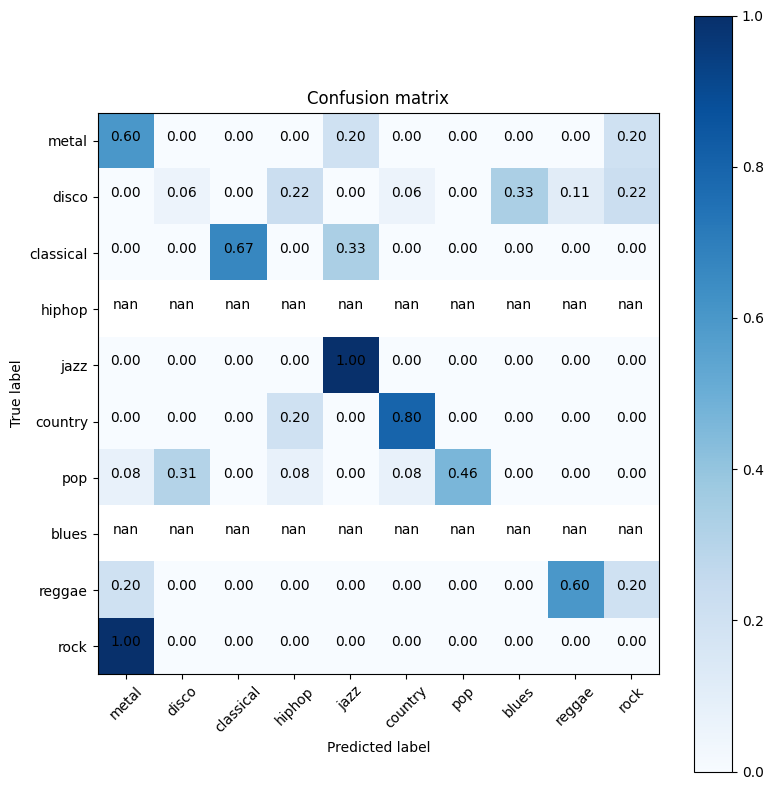

In [ ]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)

2.12.0
0.10.0.post2


InvalidArgumentError: ignored